In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from finta import TA
ticker = 'HDFCBANK.NS'  # Example: Apple Inc.
start_date = '2000-01-01'
end_date = '2024-12-31'

# Fetch the historical data
data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
data['change'] = ((data['Close'] - data['Open'])/data['Open'])*100
data['change_shifted'] = data['change'].shift(-1)
data['class'] = np.where(data['change_shifted'] > 0.5, 1, 0)



[*********************100%%**********************]  1 of 1 completed


In [3]:
ohlc = pd.DataFrame()
ohlc['open'] = data['Open']
ohlc['high'] = data['High']
ohlc['low'] = data['Low']
ohlc['close'] = data['Close'] 
ohlcv = pd.DataFrame()
ohlcv['open'] = data['Open']
ohlcv['high'] = data['High']
ohlcv['low'] = data['Low']
ohlcv['close'] = data['Close'] 
ohlcv['volume'] = data['Volume']

In [4]:
bbands = TA.BBANDS(ohlc)
ema = TA.EMA(ohlc)
rsi = TA.RSI(ohlc)
# stoch = TA.STOCHF(ohlc)
macd = TA.MACD(ohlc)
atr = TA.ATR(ohlc)
vwap = TA.VWAP(ohlcv)
obv = TA.OBV(ohlcv)
tsi = TA.TSI(ohlc)
mfi = TA.MFI(ohlcv)
kc = TA.KC(ohlc)
cci = TA.CCI(ohlc)
adx = TA.ADX(ohlc)
dmi = TA.DMI(ohlc)

df = data.copy()
df = pd.concat([df,bbands,ema,rsi,macd,atr,vwap,obv,tsi,mfi,kc,cci,adx,dmi],axis=1)

In [5]:
cutoff_date = '2000-02-21'
df_cut = df[df.index >= cutoff_date]
nan_count = df_cut.isna().sum()
nan_count

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
change             0
change_shifted     1
class              0
BB_UPPER           0
BB_MIDDLE          0
BB_LOWER           0
9 period EMA       0
14 period RSI      0
MACD               0
SIGNAL             0
14 period ATR      0
VWAP.              0
OBV               91
TSI                0
signal            11
14 period MFI      0
KC_UPPER           0
KC_LOWER           0
20 period CCI      0
14 period ADX.     0
DI+                0
DI-                0
dtype: int64

In [6]:
check = df_cut.drop('OBV' , axis=1)
check = check.drop('signal' , axis=1)
check = check.drop(check.index[-1])
check.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
change            0
change_shifted    0
class             0
BB_UPPER          0
BB_MIDDLE         0
BB_LOWER          0
9 period EMA      0
14 period RSI     0
MACD              0
SIGNAL            0
14 period ATR     0
VWAP.             0
TSI               0
14 period MFI     0
KC_UPPER          0
KC_LOWER          0
20 period CCI     0
14 period ADX.    0
DI+               0
DI-               0
dtype: int64

In [7]:
from sklearn.preprocessing import StandardScaler
x = check.drop(['change_shifted' , 'class'] , axis=1)
y = check['class']  
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42) 

### CNN Model

In [8]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Reshape data for CNN
X_train_reshaped = X_train.values.reshape(-1, X_train.shape[1], 1)
X_test_reshaped = X_test.values.reshape(-1, X_test.shape[1], 1)

# Define the model
cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn.fit(X_train_reshaped, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = cnn.evaluate(X_test_reshaped, y_test)
print("cnn accuracy:", accuracy)
# probabilities = model2.predict(X_test)
# print("Probabilities:\n", probabilities)

Epoch 1/50


/Users/lakhanbhansali/Documents/projects/Stock_market_prediction/env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6558 - loss: 0.6583 - val_accuracy: 0.6706 - val_loss: 0.6371
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6787 - loss: 0.6303 - val_accuracy: 0.6706 - val_loss: 0.6358
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6719 - loss: 0.6319 - val_accuracy: 0.6697 - val_loss: 0.6304
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6716 - loss: 0.6297 - val_accuracy: 0.6706 - val_loss: 0.6310
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6733 - loss: 0.6262 - val_accuracy: 0.6715 - val_loss: 0.6321
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6747 - loss: 0.6262 - val_accuracy: 0.6715 - val_loss: 0.6335
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6749 - loss: 0.6266 - val_accuracy: 0.6697 - val_loss: 0.6290
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6797 - loss: 0.6217 - val_accuracy: 0.6688 - val_loss: 0.6299
Epo

### MLP model

In [9]:
mlp = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
])
# Compile the model
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history = mlp.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = mlp.evaluate(X_test, y_test)
print("MLP Accuracy:", accuracy)

Epoch 1/50


/Users/lakhanbhansali/Documents/projects/Stock_market_prediction/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5310 - loss: 0.9806 - val_accuracy: 0.6706 - val_loss: 0.6832
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6286 - loss: 0.7044 - val_accuracy: 0.6706 - val_loss: 0.6747
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6464 - loss: 0.6857 - val_accuracy: 0.6706 - val_loss: 0.6661
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6712 - loss: 0.6687 - val_accuracy: 0.6706 - val_loss: 0.6583
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6572 - loss: 0.6622 - val_accuracy: 0.6706 - val_loss: 0.6512
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6621 - loss: 0.6558 - val_accuracy: 0.6706 - val_loss: 0.6459
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6747 - loss: 0.6465 - val_accuracy: 0.6706 - val_loss: 0.6422
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6651 - loss: 0.6470 - val_accuracy: 0.6706 - val_loss: 0.6399
Epo

### AUTOEncoder Model

In [10]:
ae = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
])
# Compile the model
ae.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = ae.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = ae.evaluate(X_test, y_test)
print("AutoEncoder Accuracy:", accuracy)

Epoch 1/50


/Users/lakhanbhansali/Documents/projects/Stock_market_prediction/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5566 - loss: 0.7222 - val_accuracy: 0.6706 - val_loss: 0.6545
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6553 - loss: 0.6545 - val_accuracy: 0.6706 - val_loss: 0.6479
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6684 - loss: 0.6471 - val_accuracy: 0.6706 - val_loss: 0.6429
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6728 - loss: 0.6405 - val_accuracy: 0.6706 - val_loss: 0.6404
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6779 - loss: 0.6382 - val_accuracy: 0.6706 - val_loss: 0.6384
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6614 - loss: 0.6490 - val_accuracy: 0.6706 - val_loss: 0.6355
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6623 - loss: 0.6495 - val_accuracy: 0.6706 - val_loss: 0.6342
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6746 - loss: 0.6369 - val_accuracy: 0.6706 - val_loss: 0.6348
Epo

### BiLSTM Model

In [11]:
from tensorflow.keras.layers import LSTM, Bidirectional

# Define the model
bilstm = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1))),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Reshape data for LSTM
X_train_rnn = X_train.values.reshape(-1, X_train.shape[1], 1)
X_test_rnn = X_test.values.reshape(-1, X_test.shape[1], 1)

# Compile the model
bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
bilstm.fit(X_train_rnn, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = bilstm.evaluate(X_test_rnn, y_test)
print("BiLSTM Accuracy:", accuracy)

Epoch 1/5


/Users/lakhanbhansali/Documents/projects/Stock_market_prediction/env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.6495 - loss: 0.6905 - val_accuracy: 0.6706 - val_loss: 0.6825
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.6821 - loss: 0.6793 - val_accuracy: 0.6706 - val_loss: 0.6736
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.6740 - loss: 0.6712 - val_accuracy: 0.6706 - val_loss: 0.6662
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6595 - loss: 0.6667 - val_accuracy: 0.6706 - val_loss: 0.6599
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6765 - loss: 0.6570 - val_accuracy: 0.6706 - val_loss: 0.6545
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6586 - loss: 0.6580
BiLSTM Accuracy: 0.6743044257164001


### Results

In [12]:

def evaluate_model(model, X_test, y_test):
    """
    Evaluate a given model and plot confusion matrix and classification report.
    
    Parameters:
    model (object): Trained model to evaluate.
    X_test (array-like): Features for the test set.
    y_test (array-like): True labels for the test set.
    """
    # Predict probabilities
    probabilities = model.predict(X_test)
    
    # Filter probabilities lower than 0.20 or higher than 0.80
    filtered_indices = (probabilities < 0.20) | (probabilities > 0.80)
    filtered_probabilities = probabilities[filtered_indices]
    filtered_actuals = y_test[filtered_indices.flatten()]
    
    # Get predicted classes
    predicted_classes = (filtered_probabilities > 0.5).astype(int)
    
    # Create a DataFrame for actual vs. predicted
    results = pd.DataFrame({
        'Actual': filtered_actuals,
        'Predicted': predicted_classes.flatten(),
        'Probability': filtered_probabilities.flatten()
    })
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(filtered_actuals, predicted_classes)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification Report
    class_report = classification_report(filtered_actuals, predicted_classes, output_dict=True)
    
    # Convert the classification report to a DataFrame
    report_df = pd.DataFrame(class_report).transpose()
    
    # Plot the classification report
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Classification Report')
    plt.yticks(rotation=0)
    plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


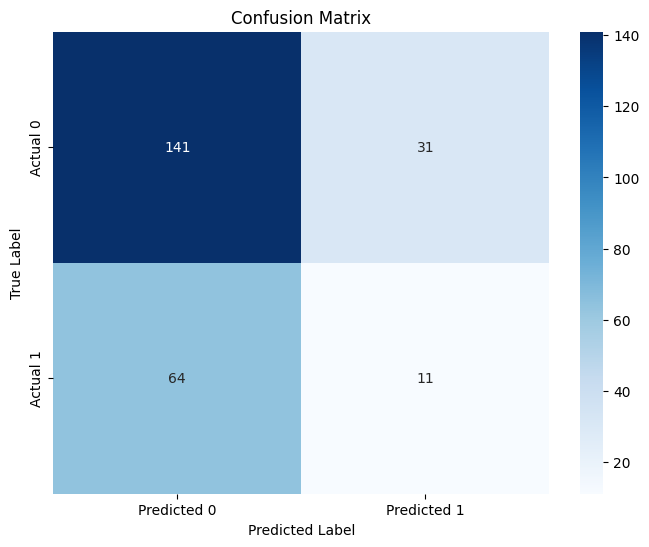

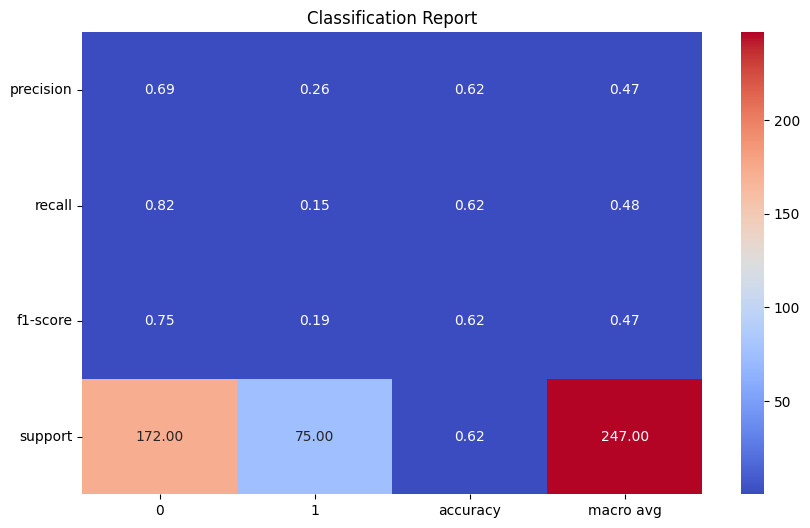

In [13]:
evaluate_model(cnn, X_test, y_test)